In [1]:
from create_datasets import read_json_dataset
from dict_utils import unfold_to_list, fold_from_list
from pipeline import Pipeline, FewShotPipeline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")


def add_lerc_preds(data, lerc_preds_dir, split):
    lerc_preds = read_json_dataset(lerc_preds_dir, split)
        
    for dataset, d in lerc_preds.items():
        for example_id, score in d.items():
            data[dataset][example_id]["LERC"] = (score["pred_score"] - 1) / (5-1)

In [2]:
DATASET_DIR = "../data/lr_experiments"
LERC_PREDS_DIR = f"{DATASET_DIR}/lerc_preds"

train = read_json_dataset(DATASET_DIR, "train_metrics")
dev = read_json_dataset(DATASET_DIR, "dev_metrics")
test = read_json_dataset(DATASET_DIR, "test_metrics")
print(len(train), len(dev), len(test))

add_lerc_preds(dev, LERC_PREDS_DIR, "dev")
add_lerc_preds(test, LERC_PREDS_DIR, "test")

train_df = pd.DataFrame(unfold_to_list(train, "dataset", "example_id"))
dev_df   = pd.DataFrame(unfold_to_list(dev, "dataset", "example_id"))
test_df  = pd.DataFrame(unfold_to_list(test, "dataset", "example_id"))
print(train_df.shape, dev_df.shape, test_df.shape)

train_df["score_scaled"] = train_df.score.apply(lambda s: (s-1)/(5-1))
dev_df["score_scaled"] = dev_df.score.apply(lambda s: (s-1)/(5-1))
test_df["score_scaled"] = test_df.score.apply(lambda s: (s-1)/(5-1))

6 6 6
(31069, 48) (4009, 49) (6321, 49)


In [3]:
DATASETS = list(train.keys())

METRICS = [
    # Bleu
    'bleu1', 'bleu2', 'bleu3', 'bleu4', 
    # 'hf_bleu1', 'hf_bleu2', 'hf_bleu3', 'hf_bleu4', 
    'rougeL', 
    # 'hf_rougeL', 'hf_rougeLsum',
    'hf_rouge1', 'hf_rouge2',
    'meteor',
    'recall', 'precision', 'f1_score',
    'sari_context', 'sari_question',
    # Token overlap when 1st error occurred
    'precision_at_err1', 'recall_at_err1',
    # Confusion matrix
    'tp', 'fn', 'fp',
    # Edit scores ------
    'char_edit_score', 'word_edit_score',
    # Learned metrics -------
    'bertscore', 'bleurt',
    # Input statistics ------
    'candidatelength_word', 'candidatelength_char',
    'candidatenunique_words', 'referencelength_word',
    'referencelength_char', 'referencenunique_words',
    'contextlength_word', 'contextlength_char',
    'contextnunique_words', 'questionlength_word',
    'questionlength_char', 'questionnunique_words',
]

TARGET = "score_scaled"

**Validate numbers reported in original MOCHA paper**

Most of the values are close to the numbers reported in the paper. The ones that are not, are consistently higher.

In [4]:
from scipy.stats import pearsonr

for dataset in DATASETS:
    print(); print("---- DEV SET ----")
    _df = dev_df[dev_df.dataset == dataset]
    print(dataset, "bleu1", round(pearsonr(_df["score_scaled"], _df["bleu1"])[0], 3))
    print(dataset, "meteor", round(pearsonr(_df["score_scaled"], _df["meteor"])[0], 3))
    print(dataset, "rougeL", round(pearsonr(_df["score_scaled"], _df["rougeL"])[0], 3))
    print(dataset, "bert-score", round(pearsonr(_df["score_scaled"], _df["bertscore"])[0], 3))
    print()
    
    print("TEST SET")
    _df = test_df[test_df.dataset == dataset]
    print(dataset, "bleu1", round(pearsonr(_df["score_scaled"], _df["bleu1"])[0], 3))
    print(dataset, "meteor", round(pearsonr(_df["score_scaled"], _df["meteor"])[0], 3))
    print(dataset, "rougeL", round(pearsonr(_df["score_scaled"], _df["rougeL"])[0], 3))
    print(dataset, "bert-score", round(pearsonr(_df["score_scaled"], _df["bertscore"])[0], 3))
    print()


---- DEV SET ----
cosmosqa bleu1 0.66
cosmosqa meteor 0.697
cosmosqa rougeL 0.702
cosmosqa bert-score 0.805

TEST SET
cosmosqa bleu1 0.671
cosmosqa meteor 0.712
cosmosqa rougeL 0.701
cosmosqa bert-score 0.78


---- DEV SET ----
drop bleu1 0.409
drop meteor 0.664
drop rougeL 0.48
drop bert-score 0.174

TEST SET
drop bleu1 0.388
drop meteor 0.568
drop rougeL 0.366
drop bert-score 0.329


---- DEV SET ----
mcscript bleu1 0.182
mcscript meteor 0.461
mcscript rougeL 0.225
mcscript bert-score 0.173

TEST SET
mcscript bleu1 0.261
mcscript meteor 0.503
mcscript rougeL 0.297
mcscript bert-score 0.195


---- DEV SET ----
narrativeqa bleu1 0.403
narrativeqa meteor 0.606
narrativeqa rougeL 0.434
narrativeqa bert-score 0.419

TEST SET
narrativeqa bleu1 0.472
narrativeqa meteor 0.616
narrativeqa rougeL 0.496
narrativeqa bert-score 0.535


---- DEV SET ----
quoref bleu1 0.675
quoref meteor 0.729
quoref rougeL 0.713
quoref bert-score 0.208

TEST SET
quoref bleu1 0.578
quoref meteor 0.716
quoref rouge

# Regression Experiments

In [5]:
# ----------------------------------------
# TODO LIST
# ----------------------------------------
# - [x] Match Pearson results w/ MOCHA paper 
#      (still do not match 100% -- why?)
# - [] Understand each metric
# - [] Differences in implementations (pycoco vs hf)
# - [] LR
# - [] LR LOO base experiment (no few shot)
# - [] L1
# - [] RF Experiments
# - [] LR LOO base experiment (w/ few shot)
# - [] LR w/ PCA
# - [] Understand Bayesian LR (MML)
# - [] Understand PCA
# - [] Read paper

In [6]:
def get_subset(df, dataset = None, col="dataset"):
    return df[df[col] == dataset].copy() if dataset else df
    
def get_all_datasets(df, datasets, include_all=True):
    result = {} if not include_all else {"all": df.copy()}
    
    for dataset in datasets:
        result.update({dataset: get_subset(df, dataset)})
        
    return result

def get_loov_datasets(df, datasets):
    result = {}

    for dataset in datasets:
        loo_datasets = [get_subset(df, d) for d in datasets if d != dataset]
        loo_dataset = pd.concat(loo_datasets)
        
        result.update({f"except_{dataset}": loo_dataset})
        
    return result

TRAIN_DATASETS = get_all_datasets(train_df, DATASETS)
DEV_DATASETS   = get_all_datasets(dev_df, DATASETS)
TEST_DATASETS  = get_all_datasets(test_df, DATASETS)

TRAIN_LOO_DATASETS = get_loov_datasets(train_df, DATASETS)

## Understand each metric (TODO)

## Differences in implementation (PyCOCO vs HF)

[__pyCOCOEvalCap__](https://github.com/salaniz/pycocoevalcap): 

[__HuggingFace__.datasets.metrics]: 

## Baseline experiments

In [10]:
from sklearn.linear_model import LinearRegression

In [30]:
def fit(
        model_class,
        model_hparams,
        features,
        target,
        train_datasets,
        split_frac=None,
        with_std=True,
        with_pca=False,
        seed=817237,
        pipeline_class=Pipeline,
    ) -> dict:
    pipelines = {}
    
    for train_name, train_data in train_datasets.items():
        pipeline = pipeline_class(model_class, model_hparams, train_name, features, target, seed=seed)
        pipeline.load_data(train_data)
        if split_frac and isinstance(split_frac, float):
            pipeline.split(holdout_fraction=split_frac)

        pipeline.preprocess(with_std=with_std, with_pca=with_pca)
        pipeline.fit()
        pipelines[train_name] = pipeline

    return pipelines


def evaluate(pipelines, eval_datasets):
    results = []
    for train_name, pipeline in pipelines.items():
        result = pipeline.evaluate_multiple(eval_datasets)
        results.extend(result)
    return results

def evaluate_loo(pipelines, eval_datasets):
    results = []
    for train_name, pipeline in pipelines.items():
        loo_dataset = train_name.rpartition("_")[-1]
        result = pipeline.evaluate_multiple({loo_dataset: eval_datasets[loo_dataset]})
        results.extend(result)

    return results

### Individual metrics

### Average

### Linear Regression

In [12]:
# All datasets experiment
ad_lr_pipelines = fit(LinearRegression, {}, METRICS, TARGET, TRAIN_DATASETS)
ad_lr_results = evaluate(ad_lr_pipelines, DEV_DATASETS)
ad_lr_results = pd.DataFrame(ad_lr_results)

loo_lr_pipelines = fit(LinearRegression, {}, METRICS, TARGET, TRAIN_LOO_DATASETS)
loo_lr_results = evaluate(loo_lr_pipelines, DEV_DATASETS)
loo_lr_results = pd.DataFrame(loo_lr_results)

# All (baseline) LR results
lr_results = pd.concat((ad_lr_results, loo_lr_results)).reset_index(drop=True)
lr_results

Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']
Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']


,mse,r2,pearson,spearman,features,target,model_classpath,model_hparams,trained_on,evaluated_on
0,0.064070,0.543574,0.738460,0.726658,"[bleu1, bleu2, bleu3, bleu4, rougeL, hf_rouge1...",score_scaled,LinearRegression,{},all,all
1,0.044982,0.700600,0.845869,0.808896,"[bleu1, bleu2, bleu3, bleu4, rougeL, hf_rouge1...",score_scaled,LinearRegression,{},all,cosmosqa
2,0.105944,0.212323,0.597415,0.565000,"[bleu1, bleu2, bleu3, bleu4, rougeL, hf_rouge1...",score_scaled,LinearRegression,{},all,drop
3,0.089830,0.386322,0.622685,0.608035,"[bleu1, bleu2, bleu3, bleu4, rougeL, hf_rouge1...",score_scaled,LinearRegression,{},all,mcscript
4,0.070816,0.527507,0.730001,0.744401,"[bleu1, bleu2, bleu3, bleu4, rougeL, hf_rouge1...",score_scaled,LinearRegression,{},all,narrativeqa
...,...,...,...,...,...,...,...,...,...,...
86,0.099708,0.258687,0.621136,0.597641,"[bleu1, bleu2, bleu3, bleu4, rougeL, hf_rouge1...",score_scaled,LinearRegression,{},except_socialiqa,drop
87,0.089803,0.386509,0.623186,0.609500,"[bleu1, bleu2, bleu3, bleu4, rougeL, hf_rouge1...",score_scaled,LinearRegression,{},except_socialiqa,mcscript
88,0.070604,0.528919,0.730395,0.746250,"[bleu1, bleu2, bleu3, bleu4, rougeL, hf_rouge1...",score_scaled,LinearRegression,{},except_socialiqa,narrativeqa
89,0.036041,0.518172,0.758751,0.735214,"[bleu1, bleu2, bleu3, bleu4, rougeL, hf_rouge1...",score_scaled,LinearRegression,{},except_socialiqa,quoref


## L1 Regression (Lasso Regression)

In [73]:
from sklearn.linear_model import Lasso

from sklearn.model_selection import ParameterSampler
from scipy.stats import expon


def get_alpha(args):
    return eval(args)["alpha"]


def plot_metric_by_alpha(data, metric, **kwargs):
    n_plots = data.trained_on.nunique()
    n_cols = 3

    n_rows = n_plots // n_cols
    n_rows += n_plots % n_cols

    position = range(1, n_plots+1)

    fig = plt.figure(1, figsize=(10, 10), dpi=150)

    for k, trained_on in enumerate(data.trained_on.unique()):
        d = data[(data["trained_on"] == trained_on)]
        ax = fig.add_subplot(n_rows, n_cols, position[k])
        sns.lineplot(data=d, x="alpha", y=metric, ax=ax, **kwargs)
        ax.set_title(f"Trained_on={trained_on}")

    plt.tight_layout()

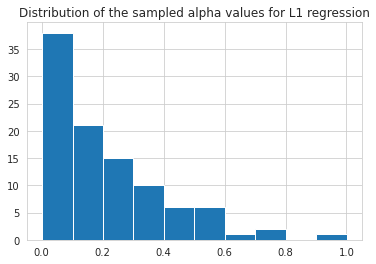

In [74]:
# We will perform model selection using L1 regression
# since it is known to enforce sparsity of the solution!
N_L1_MODELS = 100

L1_GRID = {'alpha': expon(loc=0, scale=0.20)}
L1_PARAMS = list(ParameterSampler(L1_GRID, n_iter=N_L1_MODELS, random_state=81723))

plt.hist([p["alpha"] for p in L1_PARAMS])
plt.title("Distribution of the sampled alpha values for L1 regression")
plt.show()

In [70]:
l1_pipelines = {}
ad_results = []
loo_results = []
for i, l1_hparams in enumerate(L1_PARAMS):
    if l1_hparams["alpha"] > 2:
        continue

    # All datasets experiment
    ad_l1_pipelines = fit(Lasso, l1_hparams, METRICS, TARGET, TRAIN_DATASETS)
    ad_l1_results = evaluate(ad_l1_pipelines, DEV_DATASETS)
    ad_l1_results = pd.DataFrame(ad_l1_results)
    ad_l1_results["i"] = i
    ad_results.append(ad_l1_results)

    loo_l1_pipelines = fit(Lasso, l1_hparams, METRICS, TARGET, TRAIN_LOO_DATASETS)
    # loo_l1_results = evaluate(loo_l1_pipelines, DEV_DATASETS)
    loo_l1_results = evaluate_loo(loo_l1_pipelines, DEV_DATASETS)
    loo_l1_results = pd.DataFrame(loo_l1_results)
    loo_l1_results["i"] = i
    loo_results.append(loo_l1_results)

    # All (baseline) LR results
    l1_pipelines[i] = {"AD": ad_l1_pipelines, "LOO": loo_l1_pipelines}
    
l1_ad_results = pd.concat(ad_results).reset_index(drop=True)
l1_ad_results["alpha"] = l1_ad_results["model_hparams"].apply(get_alpha)

l1_loo_results = pd.concat(loo_results).reset_index(drop=True)
l1_loo_results["alpha"] = l1_loo_results["model_hparams"].apply(get_alpha)

Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']
Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']
Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading datase

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']
Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading datase

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']
Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']
Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': [

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']
Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Load

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']
Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading 

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']
Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmos

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']
Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmos

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']
Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']
Lo

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']
Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading 

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']
Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmos

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']
Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmos

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']
Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmos

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']
Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmos

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']
Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']
Lo

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']
Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmos

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']
Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Load

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'socialiqa': ['socialiqa']
Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']
Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'dro

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']
Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmos

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']
Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']
Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']
Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']
Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmos

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']
Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']
Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/kat/miniconda3

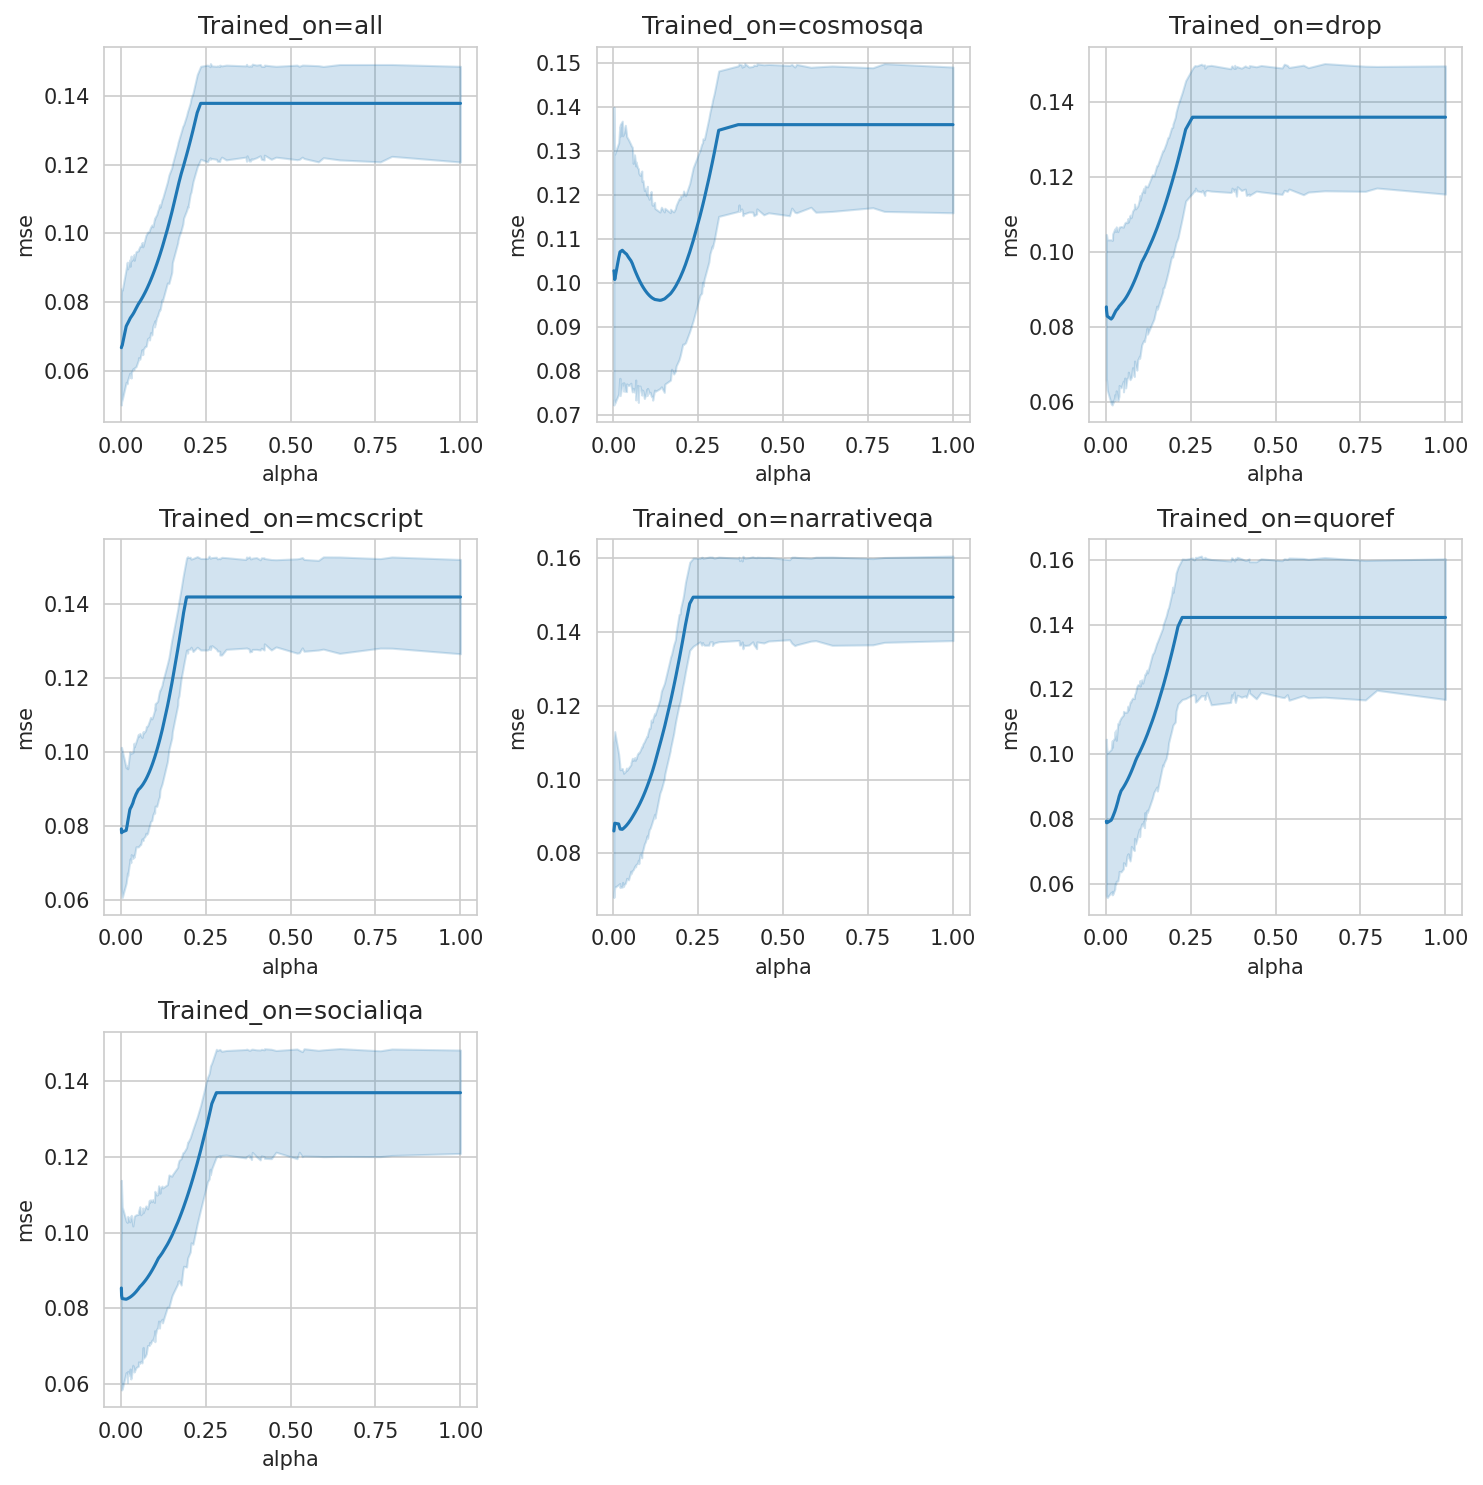

In [76]:
plot_metric_by_alpha(l1_ad_results, "mse")

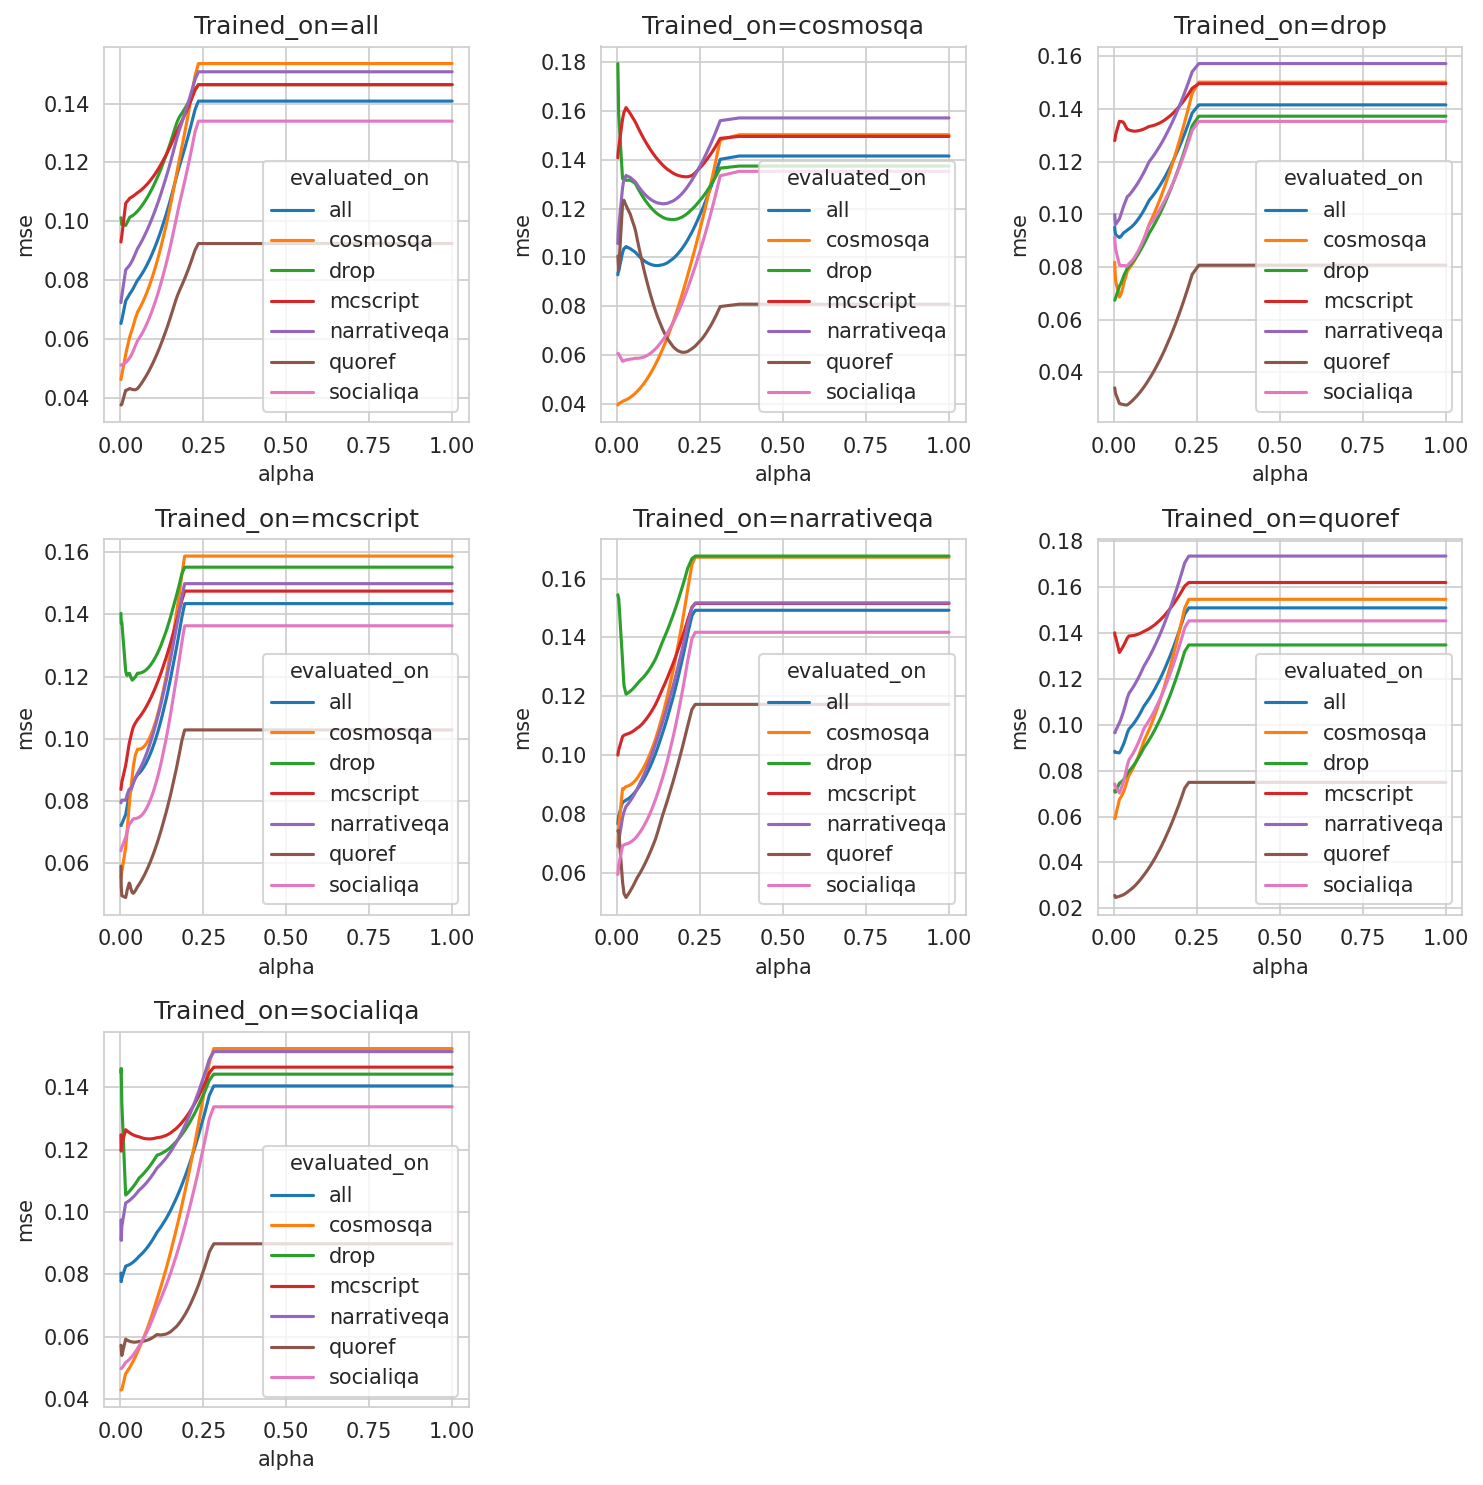

In [75]:
plot_metric_by_alpha(l1_ad_results, "mse", hue="evaluated_on")

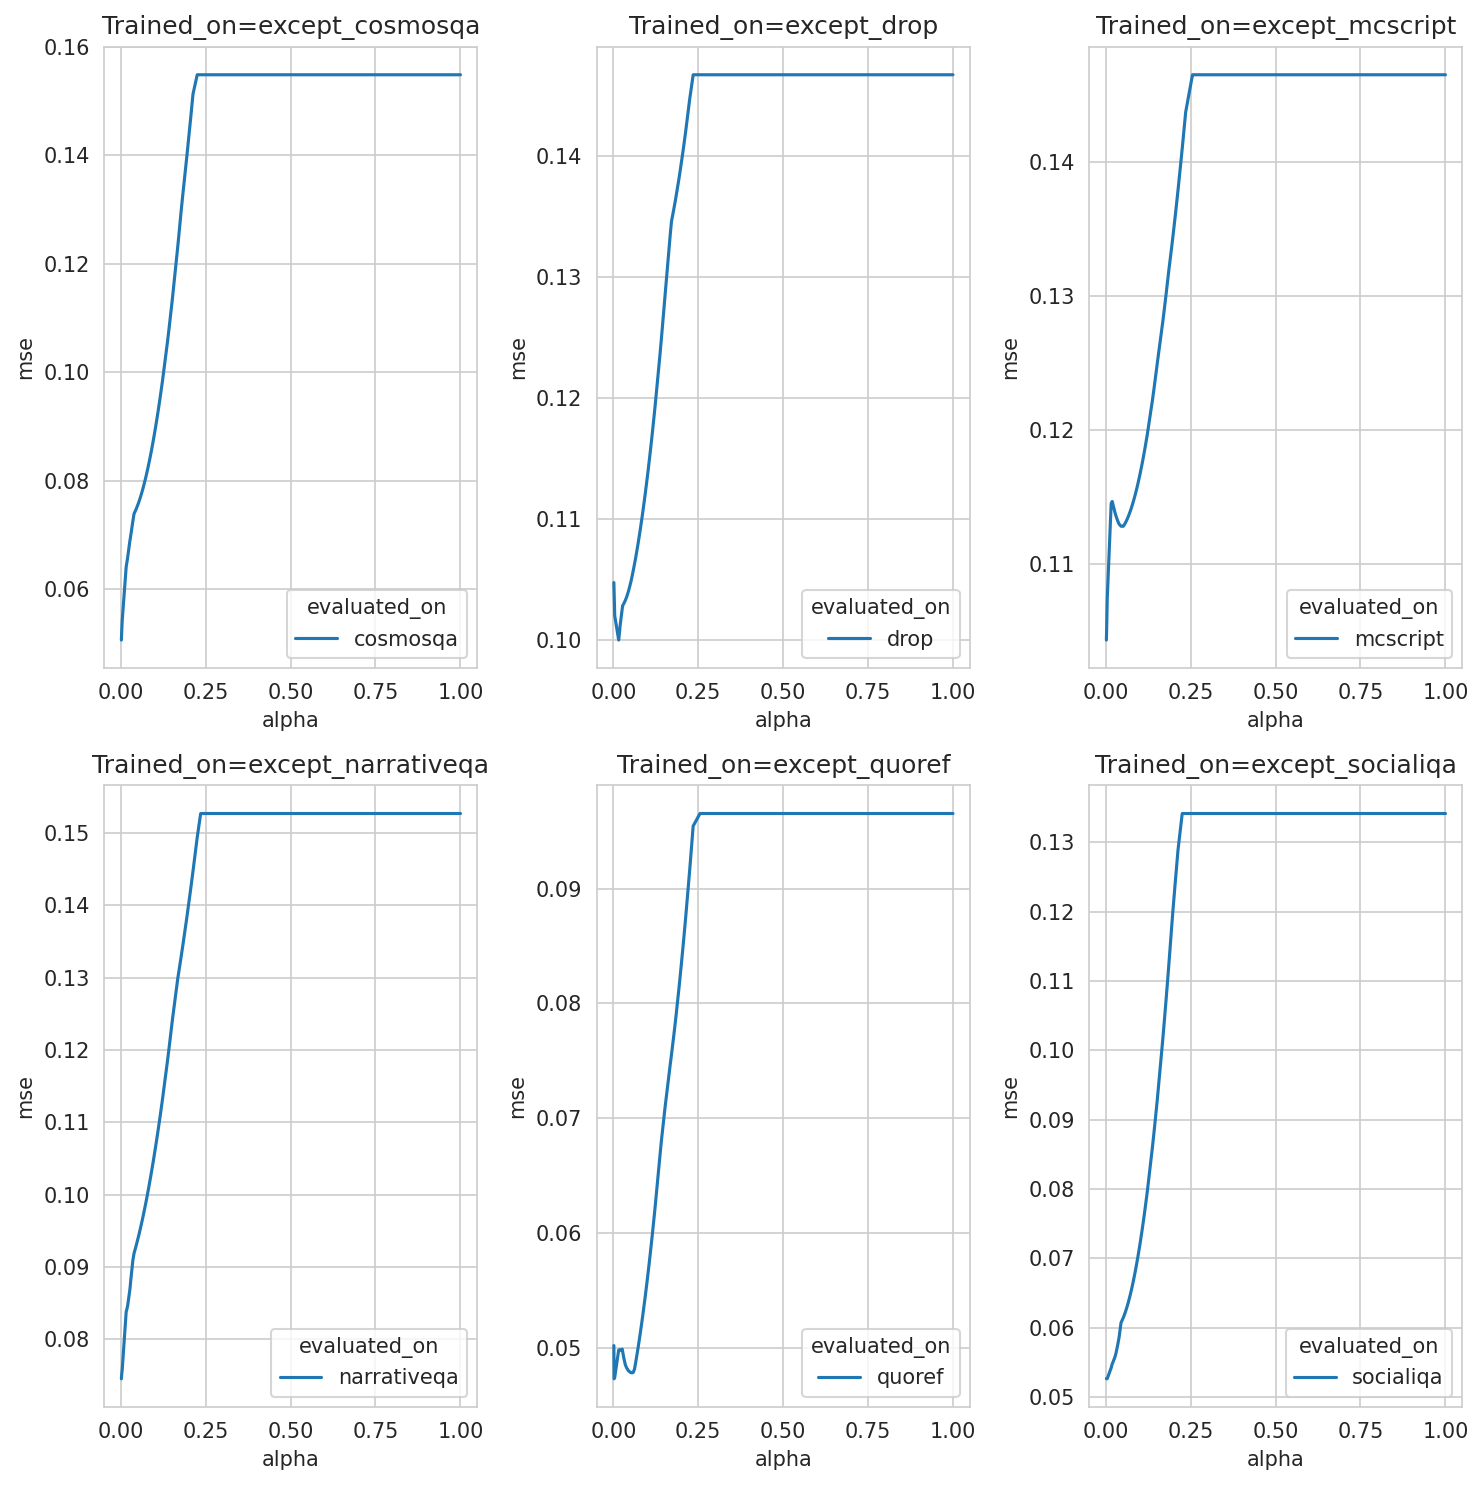

In [77]:
plot_metric_by_alpha(l1_loo_results, "mse", hue="evaluated_on")

In [ ]:
from collections import defaultdict

_n_features = defaultdict(lambda: defaultdict(list))
_n_features_names = defaultdict(set)

for i, dataset_pipelines in l1_pipelines.items():
    for dataset, pipeline in dataset_pipelines.items():
        _feat_importance = pipeline.model.coef_
        _n_feats = sum(np.abs(_feat_importance) > 1e-5)
        lasso_results.loc[
            (lasso_results["i"] == i) & (lasso_results["trained_on"] == dataset)
            , "n_features"
        ] = _n_feats
        
        _feats = np.argsort(_feat_importance)
        _feats = {features[i]: _feat_importance[i] for i in _feats}
        _n_features[dataset][_n_feats].append(_feats)
        
        _mask = np.abs(_feat_importance) > 1e-5
        _n_features_names[dataset].add(tuple(features[i] for i, e in enumerate(_mask) if e))
        
        lasso_results.loc[
            (lasso_results["i"] == i) & (lasso_results["trained_on"] == dataset)
            , "feat_importance"
        ] = str(_feats)

lasso_results

## Random Forest experiments

In [13]:
from sklearn.ensemble import RandomForestRegressor

In [14]:
# All datasets experiment
ad_rf_def_pipelines = fit(RandomForestRegressor, {}, METRICS, TARGET, TRAIN_DATASETS)
ad_rf_def_results = evaluate(ad_rf_def_pipelines, DEV_DATASETS)
ad_rf_def_results = pd.DataFrame(ad_rf_def_results)

loo_rf_def_pipelines = fit(RandomForestRegressor, {}, METRICS, TARGET, TRAIN_LOO_DATASETS)
loo_rf_def_results = evaluate(loo_rf_def_pipelines, DEV_DATASETS)
loo_rf_def_results = pd.DataFrame(loo_rf_def_results)

# All (baseline) LR results
rf_def_results = pd.concat((ad_rf_def_results, loo_rf_def_results)).reset_index(drop=True)
rf_def_results

Loading dataset 'all': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'cosmosqa': ['cosmosqa']
Loading dataset 'drop': ['drop']
Loading dataset 'mcscript': ['mcscript']
Loading dataset 'narrativeqa': ['narrativeqa']
Loading dataset 'quoref': ['quoref']
Loading dataset 'socialiqa': ['socialiqa']
Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_drop': ['cosmosqa' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_mcscript': ['cosmosqa' 'drop' 'narrativeqa' 'quoref' 'socialiqa']
Loading dataset 'except_narrativeqa': ['cosmosqa' 'drop' 'mcscript' 'quoref' 'socialiqa']
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading dataset 'except_socialiqa': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'quoref']


,mse,r2,pearson,spearman,features,target,model_classpath,model_hparams,trained_on,evaluated_on
0,0.053265,0.620543,0.789860,0.762551,"[bleu1, bleu2, bleu3, bleu4, rougeL, hf_rouge1...",score_scaled,RandomForestRegressor,{},all,all
1,0.033449,0.777366,0.884527,0.821776,"[bleu1, bleu2, bleu3, bleu4, rougeL, hf_rouge1...",score_scaled,RandomForestRegressor,{},all,cosmosqa
2,0.091649,0.318603,0.644998,0.611728,"[bleu1, bleu2, bleu3, bleu4, rougeL, hf_rouge1...",score_scaled,RandomForestRegressor,{},all,drop
3,0.072920,0.501845,0.711207,0.677334,"[bleu1, bleu2, bleu3, bleu4, rougeL, hf_rouge1...",score_scaled,RandomForestRegressor,{},all,mcscript
4,0.062164,0.585235,0.768892,0.764536,"[bleu1, bleu2, bleu3, bleu4, rougeL, hf_rouge1...",score_scaled,RandomForestRegressor,{},all,narrativeqa
...,...,...,...,...,...,...,...,...,...,...
86,0.090584,0.326527,0.647950,0.612744,"[bleu1, bleu2, bleu3, bleu4, rougeL, hf_rouge1...",score_scaled,RandomForestRegressor,{},except_socialiqa,drop
87,0.070470,0.518579,0.722956,0.683313,"[bleu1, bleu2, bleu3, bleu4, rougeL, hf_rouge1...",score_scaled,RandomForestRegressor,{},except_socialiqa,mcscript
88,0.063285,0.577754,0.763792,0.763433,"[bleu1, bleu2, bleu3, bleu4, rougeL, hf_rouge1...",score_scaled,RandomForestRegressor,{},except_socialiqa,narrativeqa
89,0.033641,0.550267,0.762290,0.768929,"[bleu1, bleu2, bleu3, bleu4, rougeL, hf_rouge1...",score_scaled,RandomForestRegressor,{},except_socialiqa,quoref


## Average Baseline

In [ ]:
for dataset in DATASET_NAMES:
    print("\n\n", dataset, sorted(_n_features_names[dataset], key=len))

In [ ]:
_n_features["quoref"][1]

In [ ]:
_n_features["narrativeqa"].keys()

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15, 5))
sns.lineplot(data=lasso_results, x="alpha", y="n_features", hue="trained_on", ax=axes[0])
axes[0].get_legend().remove()
axes[0].set_ylim(0, 10)
axes[0].set_xlim(0, 0.4)
sns.lineplot(data=lasso_results, x="alpha", y="mse", hue="trained_on", ax=axes[1])

plt.legend(title="Dataset", loc='upper left', bbox_to_anchor=(1.01, 1.02), fancybox=True)
#plt.title("Performance of L1 regressors as a function of the regularization strength")
plt.show()

In [ ]:
trained_on_all = lasso_results[lasso_results["trained_on"] == "all"]
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15, 5))
sns.lineplot(data=trained_on_all, x="alpha", y="n_features", hue="trained_on", ax=axes[0], style="trained_on", markers=["o"])
axes[0].get_legend().remove()
axes[0].set_ylim(0, 10)
axes[0].set_xlim(0, 0.4)
sns.lineplot(data=trained_on_all, x="alpha", y="mse", hue="trained_on", ax=axes[1], style="trained_on", markers=["o"])

plt.legend(title="Dataset", loc='upper left', bbox_to_anchor=(1.01, 1.02), fancybox=True)
#plt.title("Performance of L1 regressors as a function of the regularization strength")
plt.show()

In [ ]:
trained_on_all = lasso_results[lasso_results["trained_on"] == "all"]
sns.lineplot(data=trained_on_all, x="alpha", y="mse", label="MSE")
plt.ylabel("Mean Squared Error (MSE)")
plt.ylim(0, 0.2)
plt.xlim(0, 0.4)
ax2 = plt.twinx()
sns.lineplot(data=trained_on_all, x="alpha", y=trained_on_all["n_features"], label="features", color="orange", ax=ax2)
ax2.set_ylabel("Number of features")
ax2.set_ylim(0, 10)
# plt.legend(title="Dataset", loc='upper left', bbox_to_anchor=(1.01, 1.02), fancybox=True)
#plt.title("Performance of L1 regressors as a function of the regularization strength")


In [ ]:
trained_on_all[trained_on_all.n_features == 4]

In [ ]:
rs, ps = run_model_selection(Lasso, {'alpha': 0.017})

plt.figure(figsize=(4, 5))
feat_importance = ps["all"].model.coef_
sns.barplot(y=features, x=feat_importance, orient="h")

In [ ]:
dev_df[target].mean(), ps["all"].model.intercept_

In [ ]:
class AvgBaseline:
    def __init__(self, features=None, subset=None):
        if features is None or subset is None:
            self.features = None
            self.subset = None
            self.subset_feat_ids = None
        else:
            self.features = features
            self.subset = subset        
            self.subset_feat_ids = [i for i, f in enumerate(features) if f in subset]
                
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        if self.features is not None:
            X = X[:, self.subset_feat_ids]

        y_pred = np.mean(X, axis=1)
        assert len(y_pred) == X.shape[0]
        return y_pred
    
    
def get_individual_metrics():
    individual_metrics_results = []
    for feature in features[1:]:
        avg_subset_results = run_eval(AvgBaseline, {"features": features, "subset": [feature]}, train_datasets={"all": TRAIN_DATASETS["all"]})[0]
        avg_subset_results["model"] = feature
        individual_metrics_results.append(avg_subset_results)
    
    general_pipeline_with_LERC = partial(Pipeline, features=(features + ["LERC"]), target=target)
    lerc_results = run_eval(AvgBaseline, {"features": features + ["LERC"], "subset": ["LERC"]}, train_datasets={"all": EVAL_DATASETS["all"]}, pipeline=general_pipeline_with_LERC)[0]
    lerc_results["model"] = "LERC"
    individual_metrics_results.append(lerc_results)
    
    return individual_metrics_results

In [ ]:
# Baselines
avg_results, avg_pipeline = run_eval(AvgBaseline)
avg_results["model"] = "avg-all"
avg_subset_results, avg_subset_pipeline = run_eval(AvgBaseline, {"features": features, "subset": ["meteor", "rougeL", "bleurt"]})
avg_subset_results["model"] = "avg-MRB"

### Individual metrics
individual_metrics = get_individual_metrics()
individual_metrics = pd.concat(individual_metrics).reset_index(drop=True)

### Final regression models
lr_results, lr_pipeline = run_eval(LinearRegression)
lr_results["model"] = "lr"

l1_results, l1_pipeline = run_eval(Lasso, {'alpha': 0.018})
l1_results["model"] = "l1-018"
rf_results, rf_pipeline = run_eval(RandomForestRegressor)
rf_results["model"] = "rf"


all_results = pd.concat((
    avg_results,
    avg_subset_results,
    individual_metrics, 
    lr_results,
    l1_results,
    rf_results,
)).reset_index(drop=True)


In [ ]:
all_results.head()

In [ ]:
all_results.pivot(index=['trained_on', "model"], columns=['evaluated_on'], values='pearson').to_csv("pearson.csv")
all_results.pivot(index=['trained_on', "model"], columns=['evaluated_on'], values='spearman').to_csv("spearman.csv")
all_results.pivot(index=['trained_on', "model"], columns=['evaluated_on'], values='mse').to_csv("mse.csv")
all_results.pivot(index=['trained_on', "model"], columns=['evaluated_on'], values='r2').to_csv("r2.csv")

###  Average Baseline

In [ ]:
from collections import defaultdict

# Unique datasets
_unique_datasets = list(train_df.dataset.unique())

# Evaluation datasets
# includes all_datasets (macro eval), as well as individual datasets
_dev_orig_datasets = {None: dev_df}
_dev_orig_datasets.update({dataset: dev_df[dev_df.dataset == dataset] for dataset in unique_datasets})

_models = {}
_results_by_dataset = {}
for _dataset_name in _dev_orig_datasets.keys():
    if _dataset_name is None: continue
    
    # Compute other dataset names except `_dataset_name`
    _remaining_datasets = [k for k in _dev_orig_datasets.keys() if k != _dataset_name]
    
    # Select subset of trainin data that does not include `_dataset_name`
    _train_remain_df = train_df[train_df.dataset.isin(_remaining_datasets)]
    _train_remain_name = f"all_except_{_dataset_name}"
    
    print("Fitting model on", _train_remain_name, f"with {len(_train_remain_df)} examples (instead of {len(train_df)})")

    _model, _model_scalers, _valid_results = fit_model(_train_remain_df, LinearRegression)
    _models[_train_remain_name] = _model
    _results, _scores = eval_datasets(_model, _dev_orig_datasets, _model_scalers)
    _results_by_dataset[_train_remain_name] = _results
    

parse_table_results(_results_by_dataset, "dev_lr_loo_correlations", METRICS_DIR)

In [ ]:
for train_dataset in _models.keys():
    plot_model_coeffs(_models, train_dataset)

### Principal Component Analysis

We've seen there is a large correlation between the different metrics.. In particular, it might explain the coefficients, we see in the image above. In the presence of redundancy, the model may be [non-identifiable](https://en.wikipedia.org/wiki/Identifiability), i.e., have two or more parameterizations that are observationally equivalent.

In this section of the notebook, we are interested in knowing whether there will be a set of orthogonal components that fully explain the model. 

In [ ]:
def eval_datasets_with_pca(model, eval_datasets: dict, pca: dict):
    eval_results = {}
    eval_scores = {}
    for dataset_name, dataset in eval_datasets.items():
        X, y = dataset[features], dataset[target]

        X_prec = pca.transform(X.copy())

        scores = model.predict(X_prec)
        eval_results[dataset_name] = {
            "mse": metrics.mean_squared_error(y, scores),
            "r2": metrics.r2_score(y, scores),
            "pearson": pearsonr(scores, y)[0],
            "spearman": spearmanr(scores, y)[0],
        }
        eval_scores[dataset_name] = scores
    return eval_results, eval_scores

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
data = train_df.copy()
print("Considering dataset with", len(data), "examples, spanning datasets:", data.dataset.unique())

X_train, X_test, y_train, y_test = train_test_split(
    data[features], data[target], test_size=0.20, random_state=78452, stratify=data[target])
print(X_train.shape, X_test.shape)
    
# Preprocessing data (since LR may be sensitive to it)
# X_train_prec, scalers = preprocess(X_train)
# X_test_prec, _ = preprocess(X_test, scalers=scalers)


# Iterate over several components
eval_results = defaultdict(list)
_pca_models = {}
_pca = {}
for n in range(2, 20):
    print(X_train.shape, X_test.shape)
    print("Fitting PCA w/ n_components =", n)
    for seed in (123124, 1295532, 875843):
        # Create estimator
        pca = PCA(n_components=n, random_state=seed)
        X_train_transf = pca.fit_transform(X_train.copy())
        X_test_transf = pca.transform(X_test.copy())
        # print(X_train_transf.shape, X_test_transf.shape)

        # Fit LR on top of new representation
        lr = LinearRegression()
        lr.fit(X_train_transf, y_train)

        scores = lr.predict(X_test_transf)
        eval_results["n"].append(n)
        eval_results["seed"].append(n)
        eval_results["mse"].append(metrics.mean_squared_error(y_test, scores))
        eval_results["r2"].append(metrics.r2_score(y_test, scores))
        eval_results["pearson"].append(pearsonr(scores, y_test)[0])
        eval_results["spearman"].append(spearmanr(scores, y_test)[0])
        
        _pca[(n, seed)] = pca
        _pca_models[(n, seed)] = lr
        
eval_results = pd.DataFrame(eval_results)

In [ ]:
sns.lineplot(data=eval_results, x="n", y="mse")
plt.xlabel("N components (PCA)")
plt.title("MSE of fit in function of number of PCA components on dev set")
plt.xlim(0, 18)
plt.ylim(0.08, 0.15)
plt.show()

In [ ]:
n_components, seed = 10, 1295532
model = _pca_models[(n_components, seed)]

# Unique datasets
unique_datasets = list(train_df.dataset.unique())

# Evaluation datasets
# includes all_datasets (macro eval), as well as individual datasets
dev_orig_datasets = {None: dev_df}
dev_orig_datasets.update({dataset: dev_df[dev_df.dataset == dataset] for dataset in unique_datasets})

results_by_dataset = {}
for dataset_name in dev_orig_datasets.keys():
    print("Fitting model using", "all" if dataset_name is None else dataset_name, "datasets")
    results, scores = eval_datasets_with_pca(
        model=model,
        pca=_pca[(n_components, seed)], 
        eval_datasets=dev_orig_datasets,
    )
    
    results_by_dataset[dataset_name] = results 

parse_table_results(results_by_dataset, f"dev_pca_{n_components}+lr_correlations", METRICS_DIR)

In [ ]:

# Reduce dimension to 2 with PCA
pca = {i: lambda: make_pipeline(StandardScaler(), PCA(n_components=i, random_state=SEED)) for i in range(2, 15)}